In [1]:
# Import the necessary packages
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import *
from xgboost import XGBClassifier
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve

pip install 'aif360[LawSchoolGPA]'


# Pre-Modeling Bias Detection


Pre-modeling bias detection involves identifying and addressing potential biases in the data before it is used to train a machine learning model.

In [2]:
df=pd.read_csv('./data/standard_df.csv')

### Correlation Analysis
Investigate correlations between sensitive attributes and other features.

In [21]:
# Store p-values for each correlation
p_values = []
correlation_matrix=[] 
# Iterate through each predictor variable and calculate p-value for correlation
for predictor_variable in df.columns:
    if predictor_variable != 'Target':
        # Calculate Spearman correlation coefficient and p-value
        _, p_value = stats.spearmanr(df['Target'], df[predictor_variable])
        p_values.append(p_value)

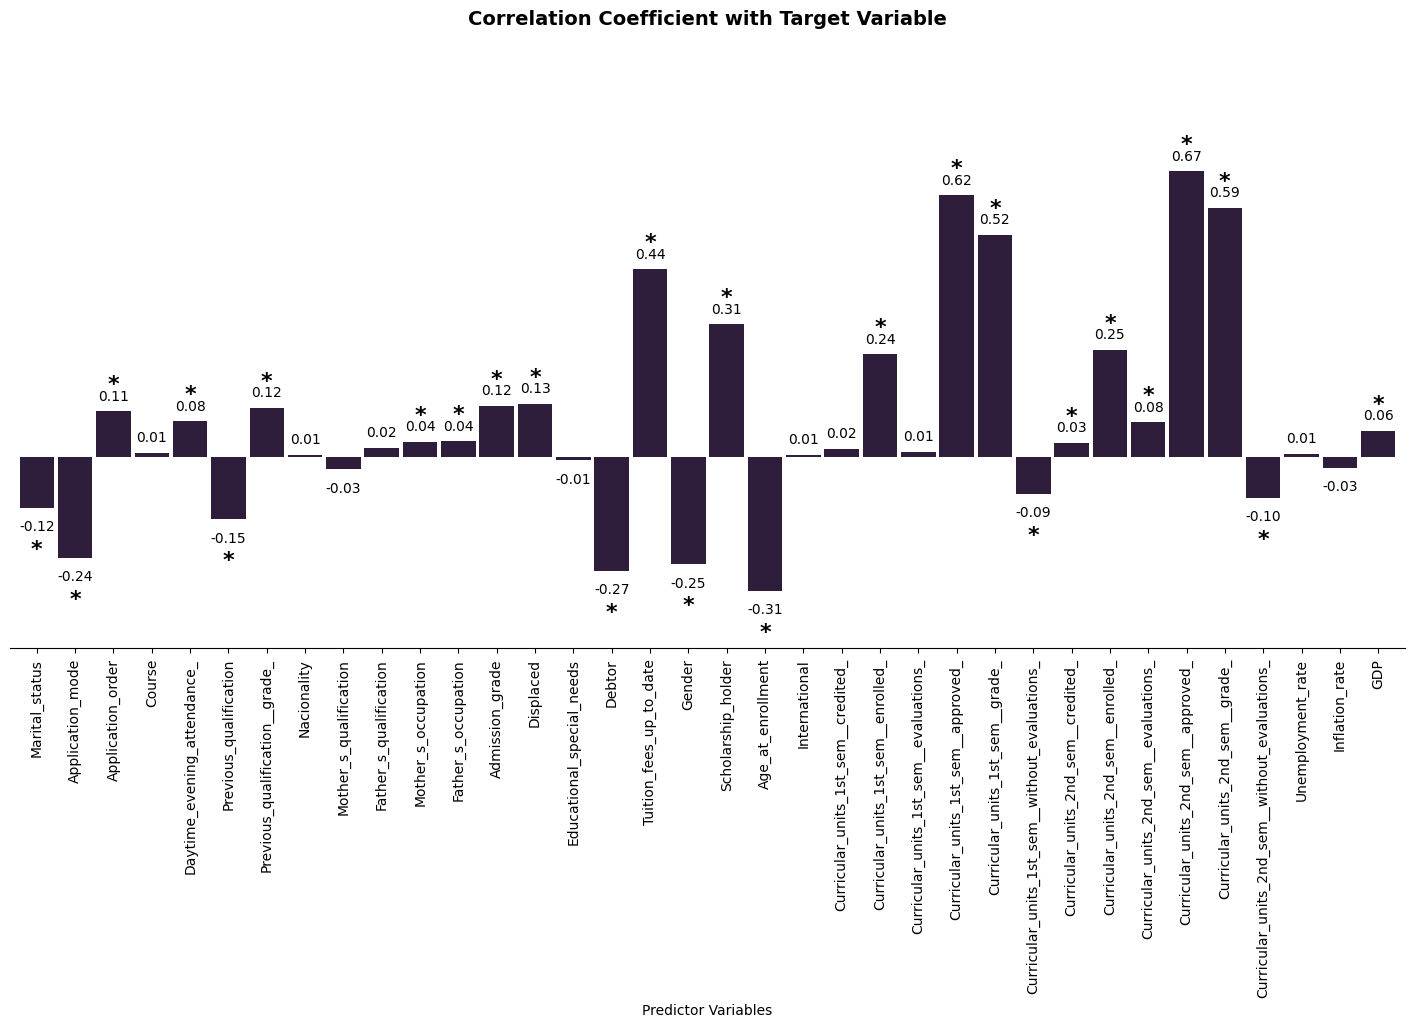

In [22]:
# Set the color palette to Mako
sns.set_palette(sns.color_palette("mako"))

# Calculate the correlation matrix
correlation_matrix = df.corr(method='spearman')['Target'].iloc[:-1]

# Create the plot
plt.figure(figsize=(18, 8))
ax = correlation_matrix.plot(kind='bar', width=0.9)  # The color is automatically set to Mako palette

# Annotate the bars with correlation coefficients and add a star if p-value < 0.05
for i, (v, p_value) in enumerate(zip(correlation_matrix, p_values)):
    ax.text(i, v + 0.02 if v >= 0 else v - 0.06, f'{v:.2f}', ha='center', va='bottom')
    if p_value < 0.05:
        ax.text(i, v + 0.04 if v >= 0 else v - 0.12, '*', ha='center', va='bottom', fontsize=16, weight='bold')

# Set title and labels
plt.title('Correlation Coefficient with Target Variable', fontsize=14, weight='bold')
plt.xlabel('Predictor Variables')

# Adjust the y-axis limits and remove ticks and labels
ax.set_ylim([-0.45, 1])
ax.set_yticks([])
ax.set_yticklabels([])

# Remove right, upper, and left axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)


In [23]:
# df.corrwith(df['Target']).iloc[:-1]



###  Kernel Density Estimation:
Visualize and compare the distribution of features for different sensitive attribute groups.

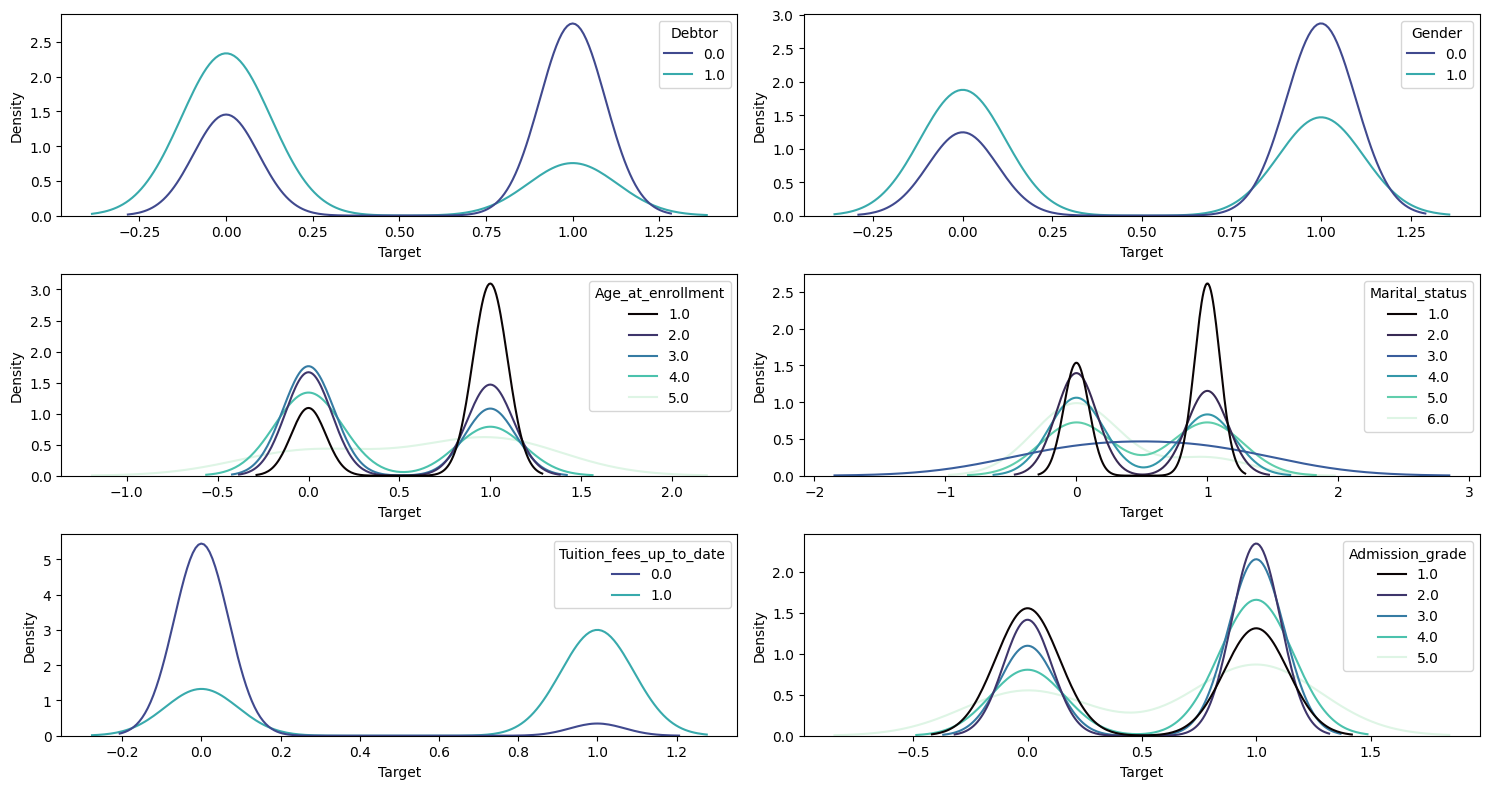

In [24]:
# Define the columns to plot
cols = ['Debtor', 'Gender', 'Age_at_enrollment', 'Marital_status', 'Tuition_fees_up_to_date', 'Admission_grade']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

# Plotting each variable using Mako palette
for i in range(3):
    for j in range(2):
        col_index = i * 2 + j
        if col_index < len(cols):
            sns.kdeplot(data=df, x='Target', hue=cols[col_index], common_norm=False, palette="mako", ax=axes[i, j])
            axes[i, j].set_xlabel('Target')
            axes[i, j].set_ylabel('Density')

# Adjust layout and save the plot
plt.tight_layout()

# Post-Modeling Bias Detection

Post-modeling bias detection involves evaluating a trained machine learning model to identify and address any biases in its predictions or performance, typically by analyzing its outputs and decision-making processes for fairness and discrimination across different groups.

In [3]:
## Load the pre-processed dataset.
df=pd.read_csv("./data/standard_df.csv")

## Create a list with the protected attributes that are going to be used. 
prot_attr=total_columns=list(df.columns)[:-1]

In [4]:
## Split the dataset and standardize it. 

X_train, X_test, y_train, y_test, indices_train, indices_test=standardized_dataset_output(
                                                                                            df,
                                                                                            prot_attr,
                                                                                            'Target'
                                                                                        )

In [5]:
## Create an XGBoost classifier
xgb_model = XGBClassifier()

## Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

## Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

## Define the predictions
y_pred=grid_search.predict(X_test)
y_proba=grid_search.predict_proba(X_test)[:,1]

In [6]:
## A dictionaty with the evaluation metrics results 
evaluation_metrics={}
evaluation_metrics["Balanced Accuracy"]=round(balanced_accuracy_score(y_test, y_pred))
evaluation_metrics["f1-score"]=round(f1_score(y_test, y_pred), 4)
evaluation_metrics["ROC-AUC"]=round(roc_auc_score(y_test, y_proba), 4)

In [7]:
## Confusion matrix results 
cm = confusion_matrix(y_test, y_pred)

## FPR, TPR results
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

## ROC-AUC results
roc_auc = roc_auc_score(y_test, y_proba)

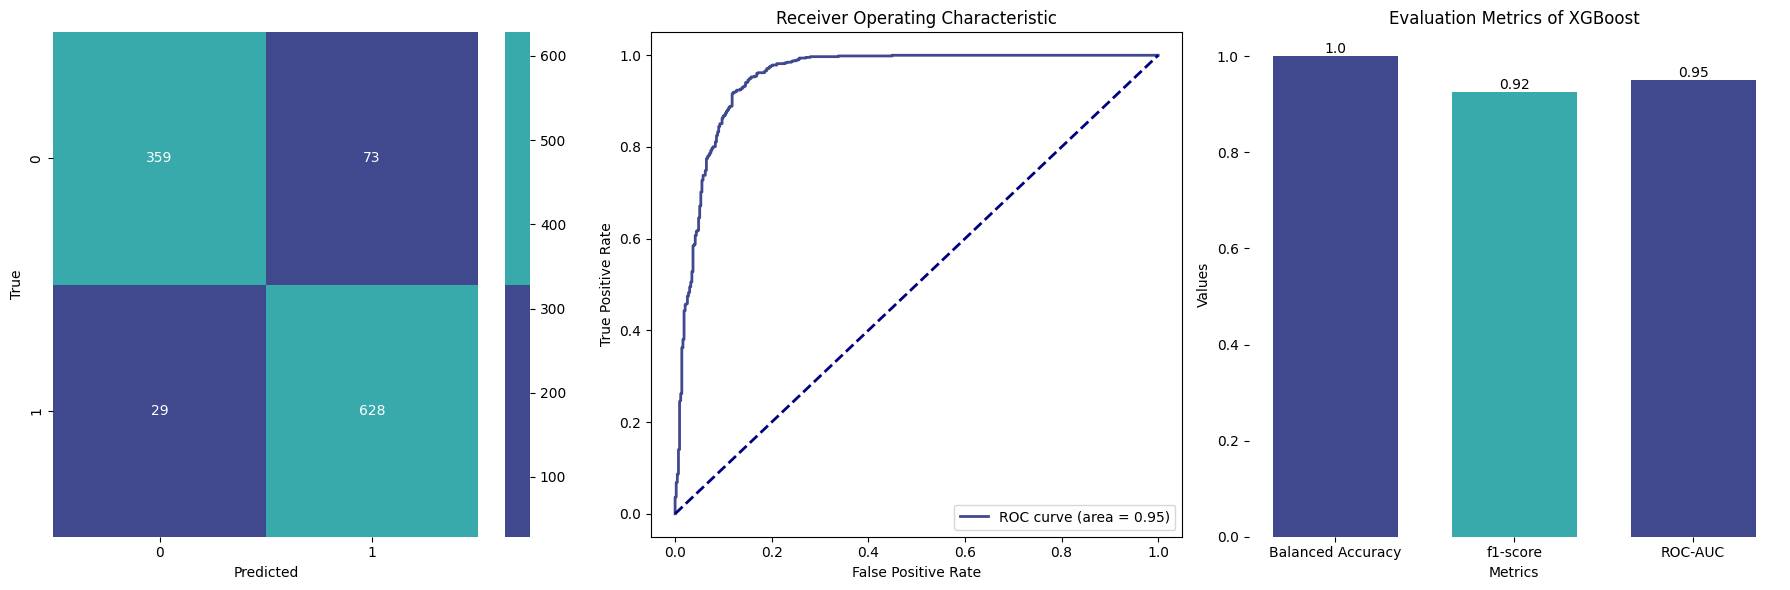

In [8]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Define a consistent color palette
palette = sns.color_palette("mako", n_colors=2)

# Plot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=axs[0], cmap=palette)
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# Plot 2: ROC Curve
axs[1].plot(fpr, tpr, color=palette[0], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('Receiver Operating Characteristic')
axs[1].legend(loc="lower right")

# Plot 3: Bar Chart of Evaluation Metrics
bar_colors = [palette[i % len(palette)] for i in range(len(evaluation_metrics))]
bars = axs[2].bar(evaluation_metrics.keys(), evaluation_metrics.values(), color=bar_colors, width=0.7)

# Adding text above each bar
for bar in bars:
    yval = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

axs[2].set_title("Evaluation Metrics of XGBoost")
axs[2].set_xlabel("Metrics")
axs[2].set_ylabel("Values")
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

In [11]:
## Calculate all the evaluation and fairness metrics of eahch protective attribute. 
xgboost_df=create_metrics_dataset(y_test, y_pred, y_proba, prot_attr)
xgboost_df

c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Ratio is ill-defined and being set to 0.0 due to no predicted privi

,Attribute,Balanced Accuracy,f1-score,ROC-AUC,Statistical Parity Difference,Disparate Impact Ratio,Equal Opportunity Difference,Average Odds Difference
0,Marital_status,0.8934,0.9249,0.9518,0.1456,1.2852,0.0198,0.0680
1,Application_mode,0.8934,0.9249,0.9518,0.3112,1.9337,-0.0442,0.0628
2,Application_order,0.8934,0.9249,0.9518,0.1537,1.2591,0.0304,0.0837
3,Course,0.8934,0.9249,0.9518,0.0762,1.1333,0.1777,-0.0117
4,Daytime_evening_attendance_,0.8934,0.9249,0.9518,-0.0706,0.8915,-0.0203,-0.0466
5,Previous_qualification,0.8934,0.9249,0.9518,0.5370,5.8333,0.4573,0.3145
6,Previous_qualification__grade_,0.8934,0.9249,0.9518,NaN,NaN,0.9559,0.0624
7,Nacionality,0.8934,0.9249,0.9518,NaN,NaN,0.9559,0.0624
8,Mother_s_qualification,0.8934,0.9249,0.9518,-0.0234,0.9649,0.0279,0.0272
9,Father_s_qualification,0.8934,0.9249,0.9518,0.0732,1.1281,0.2442,-0.0098



The analysis indicates that the variables 'Previous_qualification', 'Debtor', and 'Tuition_fees_up_to_date' exhibit the most significant discriminatory power, suggesting that these factors play a crucial role in influencing the outcomes.

In [54]:
## Create a list with the protected attributes that are going to be used. 
prot_attr=['Previous_qualification', 'Debtor', 'Tuition_fees_up_to_date']

## Keep only the protective attributes on the final metrics dataset for xgboost model.
xgboost_df=xgboost_df[xgboost_df['Attribute'].isin(prot_attr)]

In [53]:
xgboost_df.to_csv("./data/xgboost_df.csv")